In [29]:
from langgraph.graph import StateGraph, START, END
from langchain_anthropic import ChatAnthropic
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [30]:
load_dotenv()

True

In [31]:
model = ChatAnthropic(model='claude-3-5-sonnet-20241022')

In [32]:
model.invoke('hi')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'id': 'msg_014TrTjMEHM7f4ykGttWfb3Z', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 8, 'output_tokens': 12, 'server_tool_use': None, 'service_tier': 'standard', 'cache_creation': {'ephemeral_5m_input_tokens': 0, 'ephemeral_1h_input_tokens': 0}}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run--ab416444-6603-495a-8443-d56afcf5c8b3-0', usage_metadata={'input_tokens': 8, 'output_tokens': 12, 'total_tokens': 20, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})

In [33]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description='Tell the sentiment of the review')

In [34]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal['UI', 'Support', 'Bug', 'Performance', 'other'] = Field(description="tell the issue category mentioned in the review")
    tone: Literal['frustrated', 'disappointed', 'calm', 'angry', 'happy'] = Field(description='tell the tone of the person who gave the review')
    urgency: Literal['low', 'medium', 'high'] = Field(description='tell the urgency of the issue')

In [35]:
sentiment_model = model.with_structured_output(schema=SentimentSchema)
diagnosis_model = model.with_structured_output(schema=DiagnosisSchema)

In [36]:
prompt = f"what's the sentiment of the following review \n The software is too good"

In [37]:
sentiment_model.invoke(prompt).sentiment

'positive'

In [38]:
class ReviewState(TypedDict):
    review : str
    sentiment: Literal['positve', 'negative']
    diagnosis: dict
    response: str

In [50]:
def person_sentiment(state: ReviewState) -> ReviewState:
    sentiment = sentiment_model.invoke(f"tell me the sentiment of the following review \n {state['review']}").sentiment

    return {'sentiment': sentiment}


def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:
    sentiment = state['sentiment']

    if sentiment == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState) -> ReviewState:
    prompt = f"Write a thank you message in response to this review \n {state['review']}. \n Also ask the user to kindly leave positive feedback and 5 star rating"
    response = model.invoke(prompt).content

    return {'response': response}


def run_diagnosis(state: ReviewState) -> ReviewState:
    prompt = f"Run the diagnosis on this negative review \n {state['review']}. \n Return the issue type, tone and urgency"
    response = diagnosis_model.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState) -> ReviewState:
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant. User had following issue {diagnosis['issue_type']}, sounded {diagnosis['tone']} and described urgency as {diagnosis['urgency']}.
    Write a warm and empathetic review to make user feel better"""

    response = model.invoke(prompt).content

    return {'response': response}

In [51]:
graph = StateGraph(ReviewState)


graph.add_node('person_sentiment', person_sentiment)

graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)


graph.add_edge(START, "person_sentiment")


graph.add_conditional_edges("person_sentiment", check_sentiment)

graph.add_edge('positive_response', END)
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)


workflow = graph.compile()

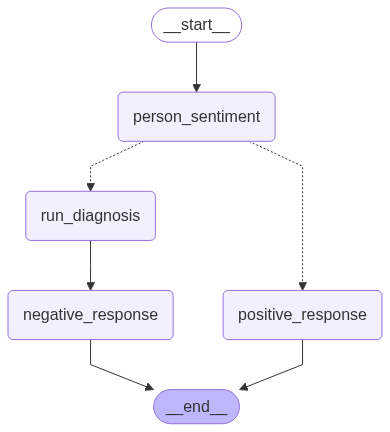

In [52]:
workflow

In [53]:
input_state = {"review":"hey I really need this update right now its been two days delay already I don't think the team is capable of doing it anymore do this else I am moving to another client"}

In [54]:
workflow.invoke(input_state)

{'review': "hey I really need this update right now its been two days delay already I don't think the team is capable of doing it anymore do this else I am moving to another client",
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Support', 'tone': 'angry', 'urgency': 'high'},
 'response': "I understand you're feeling frustrated and that this is an urgent matter causing you significant stress. I want you to know that I hear your concerns and am here to help resolve this as quickly as possible.\n\nI know it's not easy when things aren't working as they should, especially when time is of the essence. Your frustration is completely valid, and I appreciate you bringing this to our attention. Let's work together to find a solution that addresses your needs.\n\nI want to assure you that your issue is my top priority, and I'm committed to helping you through this situation. You can count on me to be thorough and responsive as we work to resolve this.\n\nWould you be comfortable sharin